# Optimise Online Sport Retail Revenue
## Introduction
Having undergone the challenging COVID-19 period, the sportswear industry experienced a market downturn and is reviving. The biggest consultancy McKinsey is bullish about the market and projects the market size would hit €395 billion in 2025 (Becker et al., 2022).

In this project, we aim to analyse the sales data and determine how the online sports clothing company can improve its revenue. We will dive into product data such as pricing, reviews, descriptions, and ratings, as well as revenue and website traffic, to propose recommendations for its marketing and sales teams.

## Data
<p>The data is collected by an online sports clothing company, and the database <code>sports</code> contains five tables, with <code>product_id</code> being the primary key for all of them: </p>
<h3 id="info"><code>info</code></h3>
<table>
<thead>
<tr>
<th>column</th>
<th>data type</th>
<th>description</th>
</tr>
</thead>
<tbody>
<tr>
<td><code>product_name</code></td>
<td><code>varchar</code></td>
<td>Name of the product</td>
</tr>
<tr>
<td><code>product_id</code></td>
<td><code>varchar</code></td>
<td>Unique ID for product</td>
</tr>
<tr>
<td><code>description</code></td>
<td><code>varchar</code></td>
<td>Description of the product</td>
</tr>
</tbody>
</table>
<h3 id="finance"><code>finance</code></h3>
<table>
<thead>
<tr>
<th>column</th>
<th>data type</th>
<th>description</th>
</tr>
</thead>
<tbody>
<tr>
<td><code>product_id</code></td>
<td><code>varchar</code></td>
<td>Unique ID for product</td>
</tr>
<tr>
<td><code>listing_price</code></td>
<td><code>float</code></td>
<td>Listing price for product</td>
</tr>
<tr>
<td><code>sale_price</code></td>
<td><code>float</code></td>
<td>Price of the product when on sale</td>
</tr>
<tr>
<td><code>discount</code></td>
<td><code>float</code></td>
<td>Discount, as a decimal, applied to the sale price</td>
</tr>
<tr>
<td><code>revenue</code></td>
<td><code>float</code></td>
<td>Amount of revenue generated by each product, in US dollars</td>
</tr>
</tbody>
</table>
<h3 id="reviews"><code>reviews</code></h3>
<table>
<thead>
<tr>
<th>column</th>
<th>data type</th>
<th>description</th>
</tr>
</thead>
<tbody>
<tr>
<td><code>product_name</code></td>
<td><code>varchar</code></td>
<td>Name of the product</td>
</tr>
<tr>
<td><code>product_id</code></td>
<td><code>varchar</code></td>
<td>Unique ID for product</td>
</tr>
<tr>
<td><code>rating</code></td>
<td><code>float</code></td>
<td>Product rating, scored from <code>1.0</code> to <code>5.0</code></td>
</tr>
<tr>
<td><code>reviews</code></td>
<td><code>float</code></td>
<td>Number of reviews for the product</td>
</tr>
</tbody>
</table>
<h3 id="traffic"><code>traffic</code></h3>
<table>
<thead>
<tr>
<th>column</th>
<th>data type</th>
<th>description</th>
</tr>
</thead>
<tbody>
<tr>
<td><code>product_id</code></td>
<td><code>varchar</code></td>
<td>Unique ID for product</td>
</tr>
<tr>
<td><code>last_visited</code></td>
<td><code>timestamp</code></td>
<td>Date and time the product was last viewed on the website</td>
</tr>
</tbody>
</table>
<h3 id="brands"><code>brands</code></h3>
<table>
<thead>
<tr>
<th>column</th>
<th>data type</th>
<th>description</th>
</tr>
</thead>
<tbody>
<tr>
<td><code>product_id</code></td>
<td><code>varchar</code></td>
<td>Unique ID for product</td>
</tr>
<tr>
<td><code>brand</code></td>
<td><code>varchar</code></td>
<td>Brand of the product</td>
</tr>
</tbody>
</table>

## Method
In this section, we will first explore all the factors that are more likely to affect the revenue performance for our client and evaluate their importance. Then, we plan to dig into the selected key factors as well as other potential topics. Finally, we classify the products into footwear and clothing categories to see which group is the cash cow.

### The Factors Driving the Revenue
To begin with, we explore the correlation for each factor on the performance of revenue. The factors here include <code>product price</code>, <code>discount</code>, <code>ratings</code>, <code>reviews</code>, and the <code>recency</code> based on the last website visit. At first, we look into the correlation between the first four factors and revenue. Reviews and price are the top factors driving the growth of revenue, giving us the direction to conduct a deeper analysis.

In [1]:
%%sql
postgresql:///sports
    
SELECT 
    ROUND(corr(f.listing_price, f.revenue)::numeric, 4) AS price_rev_corr,
    ROUND(corr(f.discount, f.revenue)::numeric, 4) AS disc_rev_corr,
    ROUND(corr(r.rating, f.revenue)::numeric, 4) AS rat_rev_corr,
    ROUND(corr(r.reviews, f.revenue)::numeric, 4) AS review_rev_corr
FROM reviews AS r
INNER JOIN finance AS f
ON r.product_id = f.product_id

1 rows affected.


price_rev_corr,disc_rev_corr,rat_rev_corr,review_rev_corr
0.4790,-0.1248,0.1145,0.6519


To calculate the <code>recency</code>, we create a temporary table of the length of the time period from the last visit to 1st January 2021.

In [2]:
%%sql

DROP TABLE IF EXISTS period;

CREATE TEMP TABLE period AS
SELECT 
    product_id,
    '2021-01-01' - last_visited::DATE AS recency
FROM traffic;

 * postgresql:///sports
Done.
3179 rows affected.


[]

The table allows us to explore the relationship between recency and revenue. It turns out that there is almost no correlation between them.

In [3]:
%%sql

SELECT ROUND(corr(p.recency::integer, f.revenue)::numeric, 4) AS rec_rev_corr
FROM period AS p
INNER JOIN finance AS f
ON p.product_id = f.product_id

 * postgresql:///sports
1 rows affected.


rec_rev_corr
0.0049


### Pricing Strategies by Brands
From the previous outcome, we know product price is one of the key factors that affect the revenue performance. To begin with, we look into the price of two popular brands Nike and Adidas, and compare their pricing strategies.

In [5]:
%%sql

WITH sales AS (
    SELECT i.product_id,
           ROUND(CAST(f.revenue / f.sale_price AS integer), 0) AS unit
    FROM info AS i
    INNER JOIN finance AS f
    ON i.product_id = f.product_id)
   
SELECT b.brand, 
    f.listing_price::integer, 
    ROUND(AVG(s.unit),0) AS avg_sales,
    COUNT(*)
FROM finance AS f
INNER JOIN brands AS b
    ON f.product_id = b.product_id
INNER JOIN sales AS s
    ON b.product_id = s.product_id
WHERE f.listing_price > 0
GROUP BY b.brand, f.listing_price
ORDER BY listing_price DESC
LIMIT 10;

 * postgresql:///sports
10 rows affected.


brand,listing_price,avg_sales,count
Adidas,300,81,2
Adidas,280,74,4
Adidas,240,83,5
Adidas,230,81,8
Adidas,220,77,11
Nike,200,0,1
Adidas,200,77,8
Adidas,190,91,7
Nike,190,21,2
Adidas,180,76,34


### Pricing Segment and Revenue
Then, we generate the pricing segment by labelling each product into different groups to make it easier to identify the trends or patterns. We can see most of Adidas' products are classified in the "Average" segment. However, products in the "Expensive" category generate the most profits.

In [6]:
%%sql

WITH sales AS (
    SELECT i.product_id,
           ROUND(CAST(f.revenue / f.sale_price AS integer), 0) AS unit
    FROM info AS i
    INNER JOIN finance AS f
    ON i.product_id = f.product_id)

SELECT b.brand, 
        COUNT(*),
        SUM(s.unit) AS total_sales,
        ROUND(SUM(f.revenue)::numeric, 0) AS total_revenue,
CASE WHEN f.listing_price < 42 THEN 'Budget'
    WHEN f.listing_price >= 42 AND f.listing_price < 74 THEN 'Average'
    WHEN f.listing_price >= 74 AND f.listing_price < 129 THEN 'Expensive'
    ELSE 'Elite' END AS price_category
FROM finance AS f
INNER JOIN brands AS b
    ON f.product_id = b.product_id
INNER JOIN sales AS s
    ON b.product_id = s.product_id
WHERE b.brand IS NOT NULL
GROUP BY ROLLUP (b.brand, price_category)
ORDER BY b.brand;

 * postgresql:///sports
11 rows affected.


brand,count,total_sales,total_revenue,price_category
Adidas,307,26588,3014317,Elite
Adidas,1060,92658,3233661,Average
Adidas,849,75602,4626980,Expensive
Adidas,359,31130,651661,Budget
Adidas,2575,225978,11526619,None
Nike,545,7340,802283,None
Nike,82,1185,128476,Elite
Nike,90,1039,71843,Expensive
Nike,357,4947,595341,Budget
Nike,16,169,6624,Average


### Discount Strategies by Brands
Based on previous research and knowledge, the discount strategy could be a significant factor to boost sales and revenue. Although discount doesn't display a strong relationship with retailer's revenue, we look deeper into this topic to examine our thoughts. We can see that Nike doesn't provide any discount on products, which probably leads to a weak correlation between discounts and revenue.

In [7]:
%%sql

SELECT b.brand, AVG(f.discount) * 100 AS average_discount
FROM brands AS b
INNER JOIN finance AS f 
    ON b.product_id = f.product_id
GROUP BY b.brand
HAVING b.brand IS NOT NULL
ORDER BY average_discount;

 * postgresql:///sports
2 rows affected.


brand,average_discount
Nike,0.0
Adidas,33.452427184465606


To evaluate the effect of discounts, we filter out all the data of Nike and keep only Adidas discount records to examine the correlation with revenue again. The previous result shows the correlation is around <b>-0.12</b>, while it grows three times to approximately <b>-0.36</b> when we look into Adidas alone.

In [8]:
%%sql

SELECT 
    b.brand, 
    ROUND(corr(f.discount, f.revenue)::numeric, 4) AS adidas_disc_cor
FROM brands AS b
INNER JOIN finance AS f 
    ON b.product_id = f.product_id
WHERE b.brand = 'Adidas'
    AND b.brand IS NOT NULL
GROUP BY b.brand;

 * postgresql:///sports
1 rows affected.


brand,adidas_disc_cor
Adidas,-0.3682


### Reviews by Month and Brands
As we know there is also a positive relationship between reviews and revenue. We continue to analyse the volume of reviews over time and compare the online response rate quarterly. The result indicates that the volume reaches its peak in the first quarter of the calendar year.

In [9]:
%%sql

SELECT b.brand,
       EXTRACT(month FROM t.last_visited) AS month,
       COUNT(r.product_id) AS num_reviews
FROM traffic AS t
INNER JOIN reviews AS r
ON t.product_id = r.product_id
INNER JOIN brands AS b
ON b.product_id = r.product_id
WHERE b.brand IS NOT NULL
    AND EXTRACT(month FROM t.last_visited) IS NOT NULL
GROUP BY b.brand, month
ORDER BY b.brand, month;

 * postgresql:///sports
24 rows affected.


brand,month,num_reviews
Adidas,1,253
Adidas,2,272
Adidas,3,269
Adidas,4,180
Adidas,5,172
Adidas,6,159
Adidas,7,170
Adidas,8,189
Adidas,9,181
Adidas,10,192


### Description Length and Ratings
After reviewing all key factors, we pay attention to other topics. With the interest in the relationship between the completeness of information and ratings, we intend to explore their correlation to see whether the length of product description will affect ratings or not. We can see there is no significant difference in ratings compared with different description lengths. However, the outcome still points out that the products without any information tend to obtain lower ratings, while the products with at least 100-word descriptions can receive better ratings.

In [10]:
%%sql

SELECT TRUNC(LENGTH(i.description), -2) AS description_length,
    ROUND(AVG(r.rating::numeric), 2) AS average_rating
FROM info AS i
INNER JOIN reviews AS r
ON i.product_id = r.product_id
WHERE i.description IS NOT NULL
GROUP BY description_length
ORDER BY description_length;

 * postgresql:///sports
7 rows affected.


description_length,average_rating
0,1.87
100,3.21
200,3.27
300,3.29
400,3.32
500,3.12
600,3.65


### Footwear Product Performance
As we know these sports brands are well-known for their footwear and sports clothing products, we decide to evaluate the performance of different product categories. However, there is no variable that specifies the product types. Hence, we create a common table expression that filters description for keywords, and then divide them into the footwear and clothing categories.

To begin with, we obtain all the products that contain keywords like <b>"shoe"</b>, <b>"trainer"</b>, and <b>"foot"</b> in the <code>footwear</code> table and assess the performance on revenue.

In [11]:
%%sql

WITH footwear AS (
    SELECT i.description, f.revenue
    FROM info AS i
    INNER JOIN finance AS f
    ON i.product_id = f.product_id
    WHERE i.description ILIKE '%shoe%'
        OR i.description ILIKE '%trainer%'
        OR i.description ILIKE '%foot%'
        AND i.description IS NOT NULL)

SELECT 
    COUNT(*) AS num_footwear_products,
    percentile_disc(0.5) WITHIN GROUP (ORDER BY revenue) AS median_footwear_revenue
FROM footwear;

 * postgresql:///sports
1 rows affected.


num_footwear_products,median_footwear_revenue
2700,3118.36


In [14]:
%%sql

WITH footwear AS (
    SELECT i.product_id, i.product_name, i.description, f.revenue
    FROM info AS i
    INNER JOIN finance AS f
    ON i.product_id = f.product_id
    WHERE i.description ILIKE '%shoe%'
        OR i.description ILIKE '%trainer%'
        OR i.description ILIKE '%foot%'
        AND i.description IS NOT NULL),
sales AS (
    SELECT i.product_id,
           ROUND(CAST(f.revenue / f.sale_price AS integer), 0) AS unit
    FROM info AS i
    INNER JOIN finance AS f
    ON i.product_id = f.product_id)

SELECT 
    f.product_name,
    SUM(s.unit) AS sales,
    f.revenue
FROM footwear AS f
INNER JOIN sales AS s
ON f.product_id = s.product_id
GROUP BY f.product_name, f.revenue
ORDER BY sales DESC
LIMIT 10;

 * postgresql:///sports
10 rows affected.


product_name,sales,revenue
Men's adidas Sport Inspired Runigma Shoes,352,6348.64
Men's adidas Sport Inspired Questar Flow Shoes,342,7180.29
Men's adidas Outdoor Hoist Light Sandals,328,2946.76
Men's adidas Originals POD-S3.1 Shoes,316,11086.42
Women's adidas Originals Supercourt Shoes,298,7169.71
Men's adidas Sports Inspired Lite Racer 2.0 Shoes,262,6043.09
Men's adidas Running Kollide Shoes,244,2936.38
Men's adidas Sport Inspired Lyrid Slip-ons,238,2731.21
Men's adidas Tennis Smash Indoor Shoes,190,2384.05
Nike Zoom Fly,189,27395.55


### Clothing Product Performance
Next, we <b>exclude</b> all products that contain keywords like <b>"shoe"</b>, <b>"trainer"</b>, and <b>"foot"</b> in the <code>footwear</code> table to form the clothing category and evaluate the performance on revenue as well.

In [15]:
%%sql

WITH footwear AS (
    SELECT i.description, f.revenue
    FROM info AS i
    INNER JOIN finance AS f
    ON i.product_id = f.product_id
    WHERE i.description ILIKE '%shoe%'
        OR i.description ILIKE '%trainer%'
        OR i.description ILIKE '%foot%'
        AND i.description IS NOT NULL)

SELECT 
    COUNT(i.*) AS num_clothing_products,
    percentile_disc(0.5) WITHIN GROUP (ORDER BY f.revenue) AS median_clothing_revenue
FROM info AS i
INNER JOIN finance AS f
ON i.product_id = f.product_id
WHERE i.description NOT IN (SELECT description FROM footwear);

 * postgresql:///sports
1 rows affected.


num_clothing_products,median_clothing_revenue
417,503.82


In [16]:
%%sql

WITH footwear AS (
    SELECT i.description, f.revenue
    FROM info AS i
    INNER JOIN finance AS f
    ON i.product_id = f.product_id
    WHERE i.description ILIKE '%shoe%'
        OR i.description ILIKE '%trainer%'
        OR i.description ILIKE '%foot%'
        AND i.description IS NOT NULL),
sales AS (
    SELECT i.product_id,
           ROUND(CAST(f.revenue / f.sale_price AS integer), 0) AS unit
    FROM info AS i
    INNER JOIN finance AS f
    ON i.product_id = f.product_id)

SELECT 
    i.product_name,
    SUM(s.unit) AS sales,
    f.revenue
FROM info AS i
INNER JOIN finance AS f
ON i.product_id = f.product_id
INNER JOIN sales AS s
ON i.product_id = s.product_id
WHERE i.description NOT IN (SELECT description FROM footwear)
GROUP BY i.product_name, f.revenue
ORDER BY sales DESC
LIMIT 10;

 * postgresql:///sports
10 rows affected.


product_name,sales,revenue
Air Jordan 10 Retro,401,64203.93
Men's adidas Toe Side II Slippers,178,1388.18
Men's adidas Comfort Flip Flops,176,4937.44
Men's adidas Originals 424 SC Premiere Shoes,175,22696.25
Men's Football Nemeziz 19.3 Firm Ground Cleats,175,8728.25
MEN'S ADIDAS FOOTBALL COPA 18.3 FIRM GROUND BOOTS,173,5182.27
Men's Originals Summer Adilette Slides,171,5128.29
Men's adidas Originals Arsenal Adilette Shower Slides,169,5074.31
Women's adidas Swim Jung Slippers,167,1002.73
men's ADIDAS RUNNING TYLO SHOES,167,4685.53


## Analysis

In this project, we aim to analyse the driving factors for revenue and optimise profit performance. Given the sale records provided by our client, we identify the elements that contribute to revenue and spot the opportunity for improvement in the sale process. In this section, we will explore the relationship between each candidate factor and revenue and generate insights and strategies, including strengthening its advantages, improving capability and innovation.

In the analysis, we can obtain the factors <b>listing price</b>, <b>discount</b>, <b>ratings</b>, <b>reviews</b>, and <b>recency</b> from the database after understanding the data set. To initialise our analysis, we look into these factors' correlations to obtain a big picture. Table 1 points out the number of <b>reviews</b> show a strong relationship with revenue, followed by the product <b>price</b> with a moderate correlation. By contrast, there is no striking patterns in the factor <b>discount</b>, <b>ratings</b>, and especially <b>recency</b>. The initial outcome allows us to propose relevant strategies to optimise our client's profit performance.</p>

Table 1. The correlation of selected factors with revenue

<table>
<thead>
<tr><th>Price</th><th>Discount</th><th>Ratings</th><th>Reviews</th><th>Recency</th></tr>
</thead>
<tbody>
<tr><td>0.4790</td><td>-0.1248</td><td>0.1145</td><td>0.6519</td><td>0.0049</td></tr>
</tbody>
</table>

Given that product price has a moderate correlation affecting the client's revenue, we're interested in how the <b>price</b> and <b>sales</b> can be different in these brands and the price distribution in their product portfolio (Figure 1.). At first, we can recognise there is a huge gap in average sales of each product between Nike and Adidas. Generally, the sales of Adidas' products surpass that of Nike's products, dominating the sale performance of our client. In terms of variety, Adidas has a larger quantity than Nike, with over 1,000 kinds of products. Adidas also possess a broad pricing range, from \\$9 to \\$300, and most products are priced from \\$50 to \\$90. By contrast, there are only 190 different Nike products and, the pricing is ranged from \\$30 to \\$200. On the one hand, we cannot deny the popularity of Adidas and the profitability of the client's revenue structure. On the other hand, we notice the lack of product diversity in Nike's products.

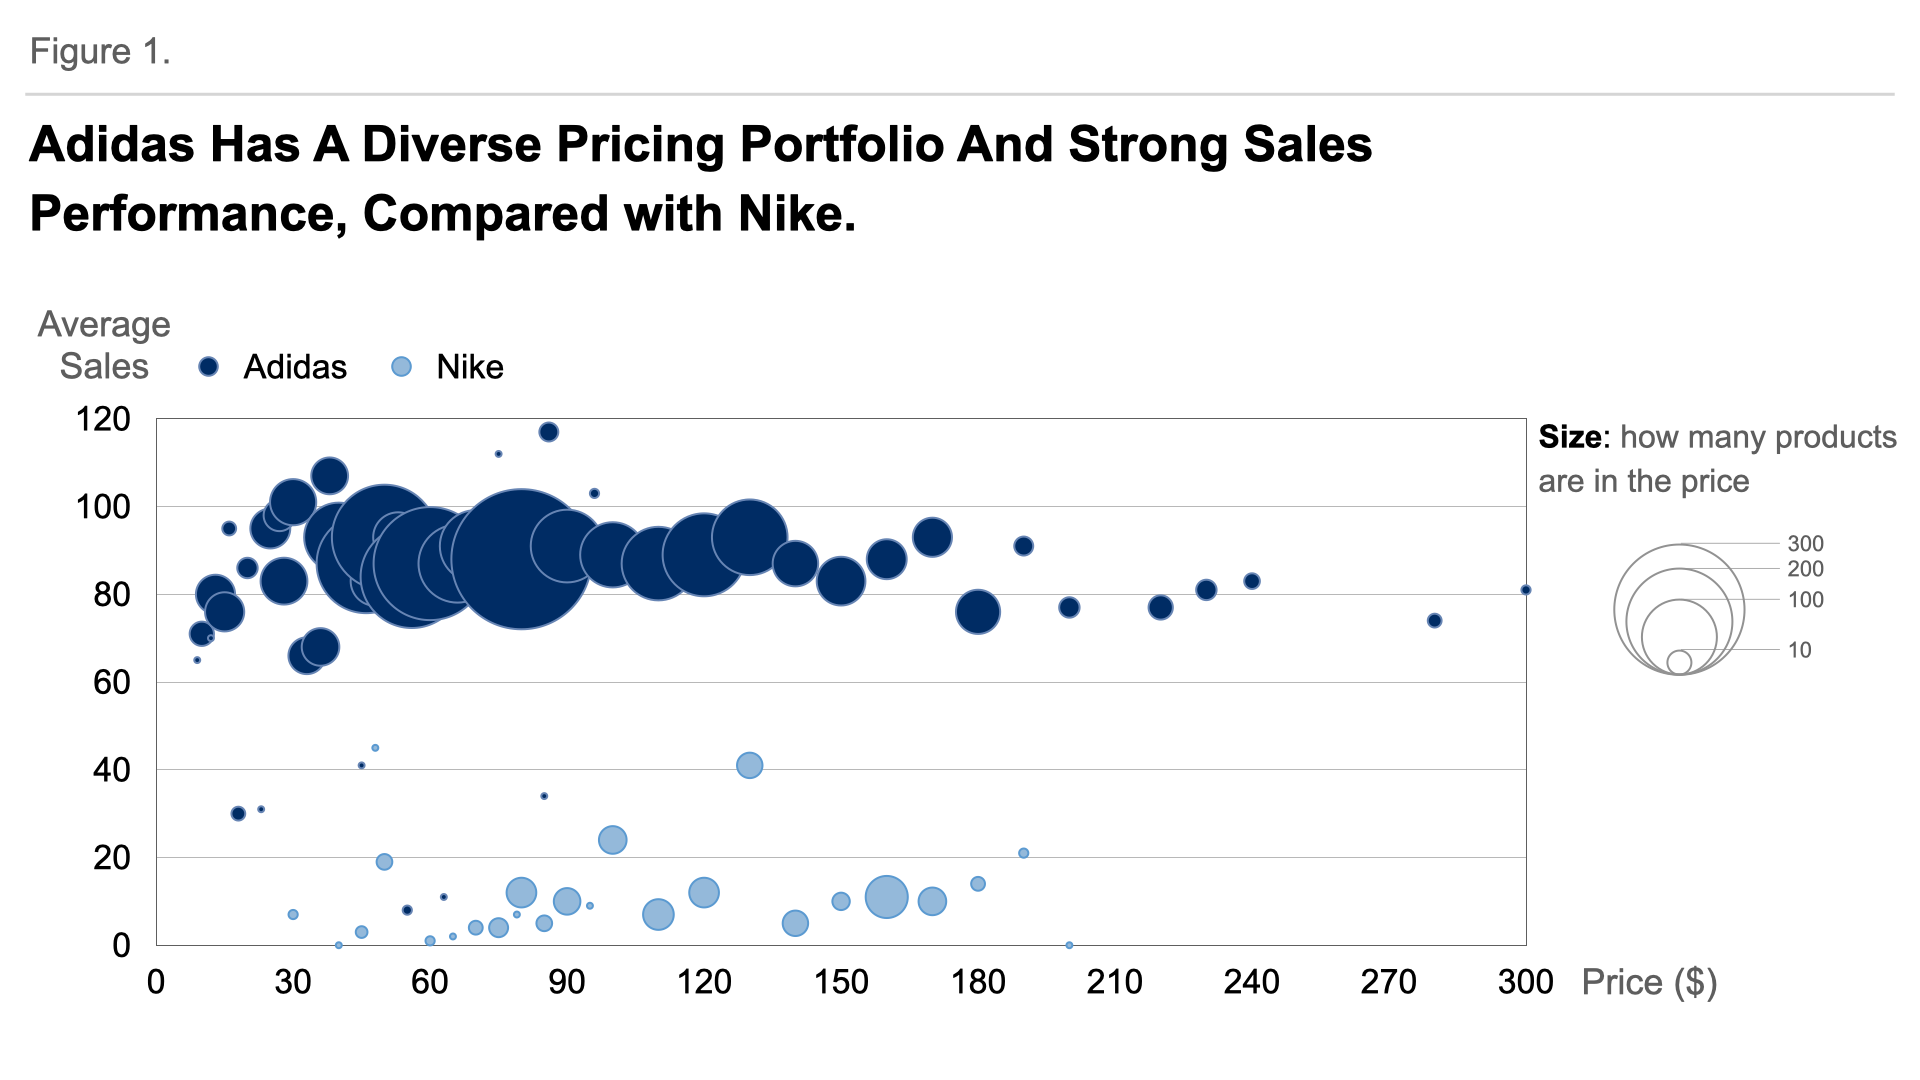

Then, we plan to measure the effects of different pricing on revenue by labelling products into four pricing segments (Elite, Expensive, Average, and Budget) from the highest to the lowest pricing range (Figure 2.). In Adidas alone, the <b>Elite</b> products generate over one-quarter of revenue even though they only account for 12% of sales. Likewise, its <b>Expensive</b> category makes up 40% of revenue with a sale share of 33%. We can see that 66% of revenue comes from the high-priced products, which only account for 45% of sales. However, there is an opposite trend in Nike. The <b>Budget</b> category demonstrates better performance and is the only one with an increase in the percentage of revenue against the percentage of sales. 

Additionally, we evaluate the previous result (Figure 1.) and the pricing segments (Figure 2.) at the same time, there is an unbalanced ratio of four categories in Nike. Over 65% of Nike's products are priced in the <b>Budget</b> category, leading to a concentrated revenue percentage in the category. For Adidas, we can discover that the <b>Elite</b> category only occupies 12% of total products but actually generate 26% of total revenue.

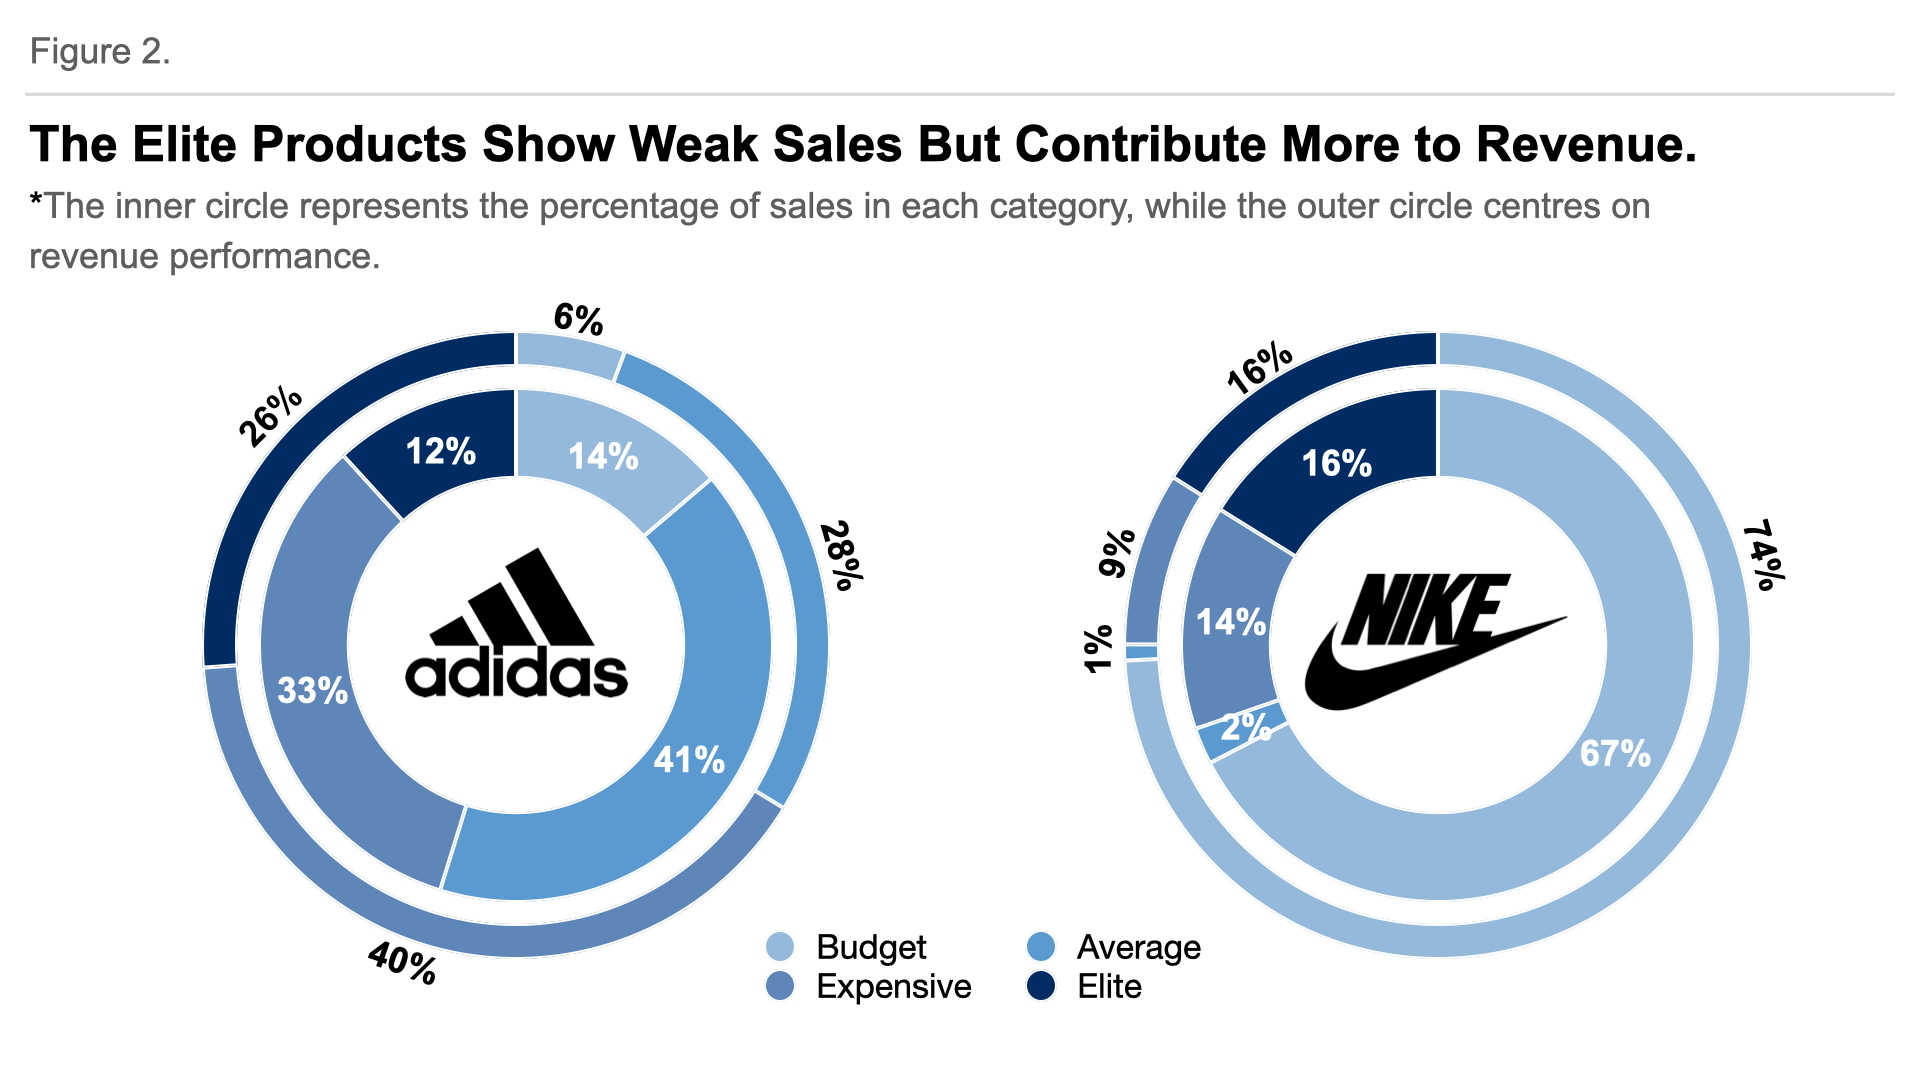

As aforementioned, we know that the number of <b>reviews</b> displays the strong relationship with revenue. As a key factor of revenue growth, we examine reviews performance throughout the whole year and compare each quarter's result to measure the social volume. Figure 3 displays that product reviews are highest in the first quarter of the calendar year for both brands. Hence, there is a scope to run experiments aiming to increase the volume of reviews in the other nine months, in turn enhancing revenue performance.

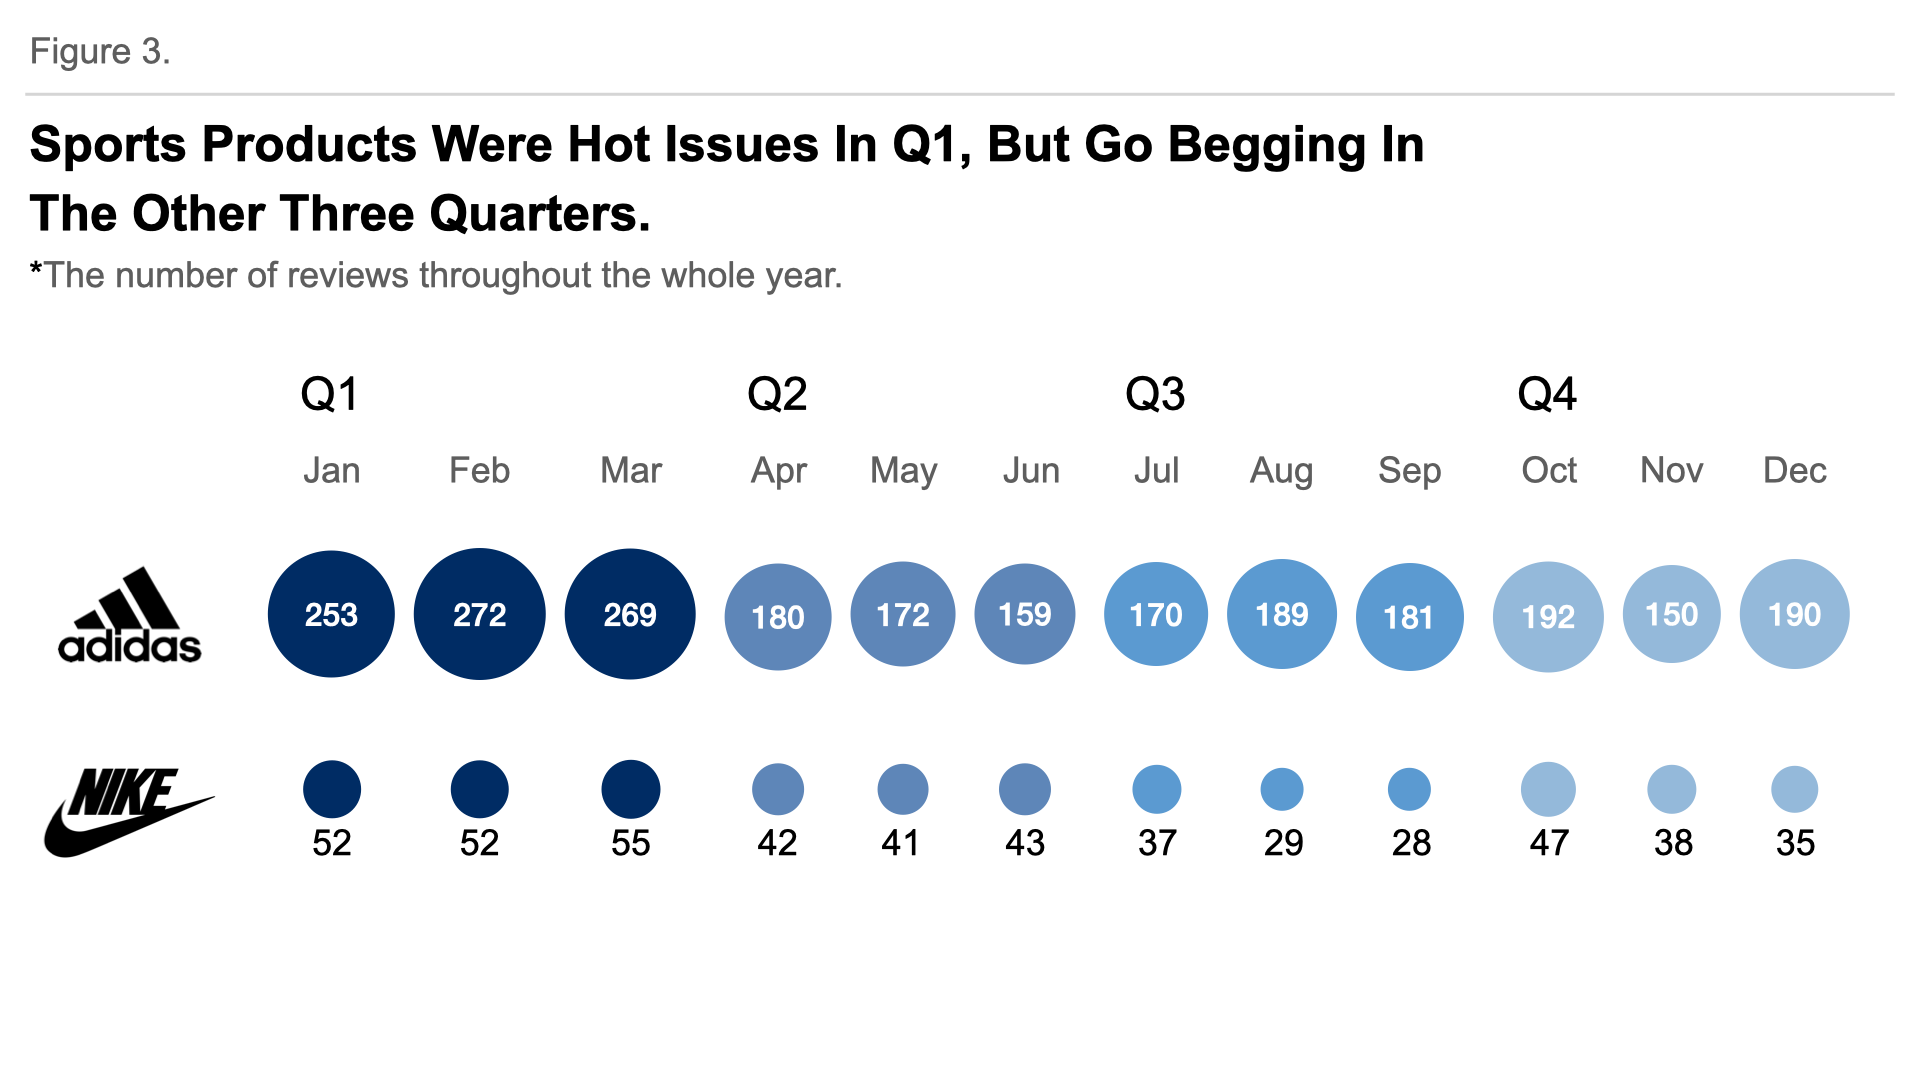

Finally, we compare two product categories and assess their performance on revenue (Table 2.). Due to the extreme revenue distribution, we consider the median revenue to evaluate the effect. Of all products, the footwear categoty accounts for around 85% of company stock and generate a median revenue of over \\$3000 for each product, while the clothing category only earn a median revenue of about \$500. The footwear products are more favoured by customers than the clothing products. When exploring deeper, we can identify the best seller in different categories and also the cash cow products that generate the most revenue.

Table 2. The comparison of product numbers and median revenue

<table>
<thead>
<tr><th>Category</th><th>The Number of Products</th><th>Median Revenue</th><th>The Best Seller</th><th>The Cash Cow</th></tr>
</thead>
<tbody>
<tr><td>Footwear</td><td>2700</td><td>3,118.36</td><td>Men's adidas Sport Inspired Runigma Shoes</td><td>Unisex Originals CRAIG GREEN KONTUUR II SHOES</td></tr>
</thead>
<tbody>
<tr><td>Clothing</td><td>417</td><td>503.82</td><td>Air Jordan 10 Retro</td><td>Air Jordan 10 Retro</td></tr>
</tbody>
</table>

## Conclusion and Recommendation

This project aims to optimise our client's revenue performance by looking into several controllable factors. Based on our analyses, we recommend our client propose relevant strategies with the following directions:

<b>1. Increase the product diversity in Nike and maintain the popularity of Adidas.</b>

Given that the huge gap between Adidas and Nike, we should introduce more kinds of Nike's products for customers, increasing the variety of product types and pricings. Likewise, we probably fail to fairly compare the performance of two brands due to the unbalanced ratio between two brands. Hence, we expect a reasonable and insightful comparison after the improvement in the number of Nike products. So far, we can see that Adidas products have higher revenue in average. Most of our client's customers are a fan of Adidas. In addition to the product variety, I would also recommend our client to hold relevant events with Adidas to cater to its customers' preference.

<b>2. Adjust product portfolio based on buyers' preference.</b>

As knowing the Adidas buyers prefer the high-priced products, such as the <b>Elite</b> and <b>Expensive</b> categories, we suggest the client should keep eye on satifying customers with these categories. Especially the <b>Elite</b> products, they only account for 12% of sales but generate 26% of revenue, and we, thereby, increase the number of the <b>Elite</b> products, which only occuped 12% of total products.

With the concentration (85%) of the <b>Budget</b> category in Nike, we need to introduce more products of other pricing segments to balance the ratio. We expect a more comparable result after the implementation. For now, we can still see that the <b>Budget</b> products are more favoured by Nike buyers.

<b>3. Conduct experiment to boost volume of reviews.</b>

From the quarter result of review numbers, we spot the opportunity to improve the review volume in Q2, Q3 and Q4. Thus, we recommend our client  conduct several experiments to encourage customers to leave their opinions on the product pages. One approach could be to offer small discounts or reward points after they comment on products, ehancing the interaction with customers and social volume.

<b>4. Research on popular products and consider the removal of unpopular products.</b>

We already identify the best sellers and the cash cow products for our client. This allows us to research on their style, colour, types and analyse the industry trends and customer preferences for the product launch in the following seasons. Meanwhile, we can also find there are so many products without any sale. We suggest that our client can do promotions to distinguish whether products are outdated or not favoured by customers, and then decide to remove them or not.